In [96]:
# Numpy imports:
import numpy as np

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

In [8]:
import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

In [81]:
#This should not change between experiments:
datapath = '../../data/atp_hydro'
#This varies between experiments.  
datafolder = '2023-01-25_ATeamAsters_5/Pos1'

# # YFP Images
# included_YFP = 'YFP/*Pos1.*.tif'
# YFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))

# # CFP Images
# included_CFP = 'CFP/*Pos1.*.tif'
# CFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))

#--------- DELETE -----------#
# YFP Images
included_YFP = 'YFP/*Pos1.*.tif'
YFP_files_batch1 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))
included_YFP = 'YFP/*Pos1_1*.tif'
YFP_files_batch2 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))
YFP_files = np.concatenate((YFP_files_batch1, YFP_files_batch2), axis=0)

# CFP Images
included_CFP = 'CFP/*Pos1.*.tif'
CFP_files_batch1 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))
included_CFP = 'CFP/*Pos1_1*.tif'
CFP_files_batch2 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))
CFP_files = np.concatenate((CFP_files_batch1, CFP_files_batch2), axis=0)
#--------------

#Read in images and save as array:
YFP_array = atp_hydro.file_to_image(YFP_files)
CFP_array = atp_hydro.file_to_image(CFP_files)

# ------------------------------------------------------------------------------ #
#Background - use no motor no ATeam no ATP condition from 2023-01-23 Cal Curve
#bgfolder = '../../data/atp_cal/2023-01-23_ATeam(new)_CalCurve/2023-01-23_ATeam(new)_CalCurve_1/images/'
YFP_bg = 1919
CFP_bg = 1917

In [63]:
#Circular data imma crop - not for the real thing

In [83]:
YFP_array = YFP_array[:, 400:900, 700:1200]
CFP_array = CFP_array[:, 400:900, 700:1200]

In [84]:
YFP_array.shape

(450, 500, 500)

In [85]:
#Subtract im_dark from all calibration images
YFP_bs = YFP_array - YFP_bg
CFP_bs = CFP_array - CFP_bg

#set negative values to zero
CFP_bs[CFP_bs<0] = 0
YFP_bs[YFP_bs<0] = 0

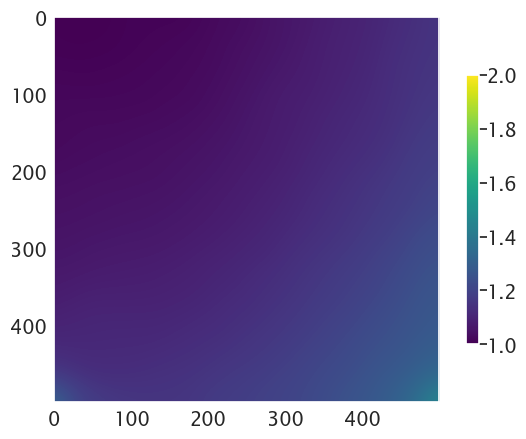

In [86]:
#Find the normilization matrix
YFP_norm_mat = atp_hydro.norm_mat_fn_iATP(YFP_array[-1], YFP_bg)
CFP_norm_mat = atp_hydro.norm_mat_fn_iATP(CFP_array[-1], CFP_bg)

#plot the normalizaiton matrix
plt.imshow(CFP_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [87]:
#Normalize all the claibration images by multiplying by the normalization matrix
YFP_norm = YFP_bs*YFP_norm_mat
CFP_norm = CFP_bs*CFP_norm_mat

In [88]:
#Average intensities
YFP_hydro = np.average(YFP_norm, axis=(1,2))
CFP_hydro = np.average(CFP_norm, axis=(1,2))
ratio_hydro = YFP_hydro/CFP_hydro

In [89]:
time = np.arange(0, len(ratio_hydro), 1)*20 #s

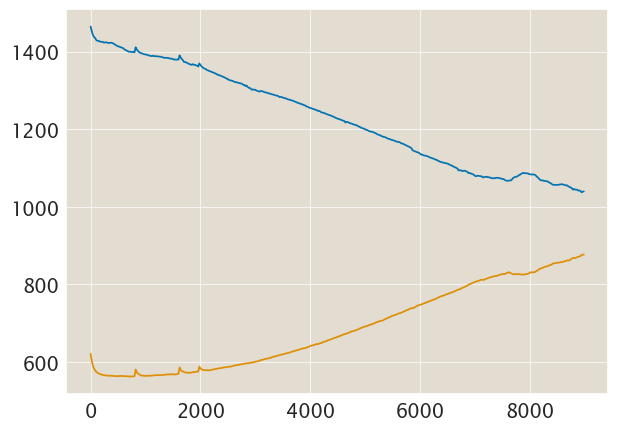

In [90]:
plt.plot(time, YFP_hydro)
plt.plot(time, CFP_hydro)

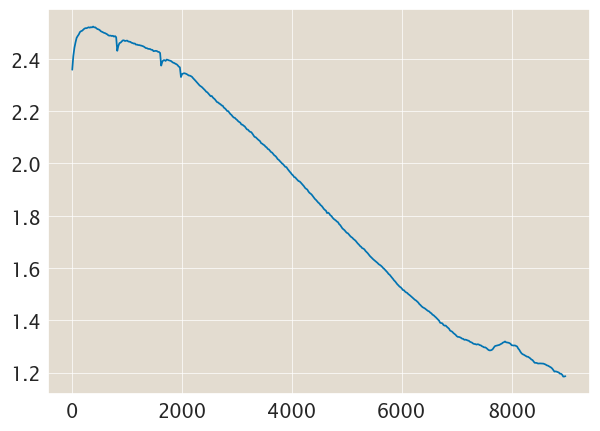

In [91]:
plt.plot(time, ratio_hydro)

In [92]:
def ATP_inten_to_conc(array, a, b, c, d):
    return a * ((c - array) / (array - b)) ** (1/d)

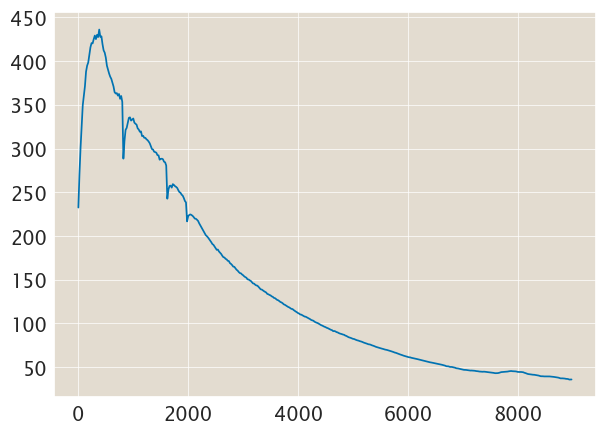

In [93]:
ratio_concavg1 = ATP_inten_to_conc(ratio_hydro, 80.37, 2.63, 0.8, 1.64)
plt.plot(time, ratio_concavg1, label = 'omitted 88')

In [106]:
def expfunc(time, tau, Ao, Ainf):
    return (Ao-Ainf)*np.exp(-time/tau) + Ainf
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1], param[2])
    
    return param, curve

In [107]:
params, curve = expfit(time[19:], ratio_concavg1[19:], [2000, 500, 50])

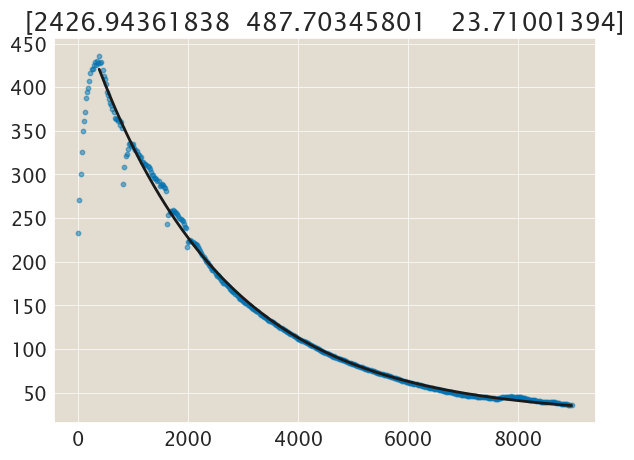

In [108]:
plt.scatter(time, ratio_concavg1, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)
plt.title(str(params));

In [109]:
ATPsat = np.max(ratio_concavg1) #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.3700423668861288


In [94]:
def expfunc(time, tau, Ao):
    return Ao*np.exp(-time/tau)
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(2), np.ones([2])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1])
    
    return param, curve

In [97]:
params, curve = expfit(time[19:], ratio_concavg1[19:], [2000, 600])

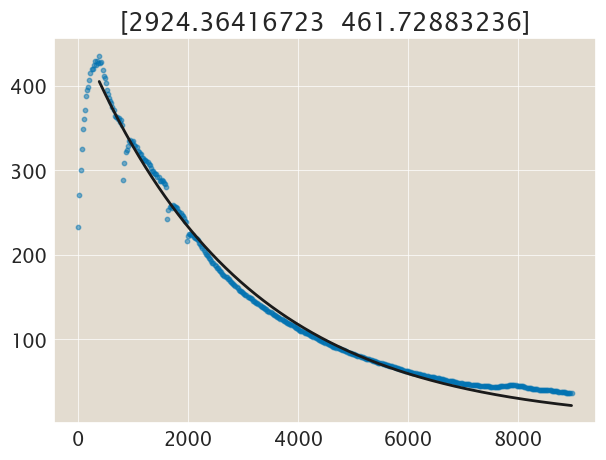

In [98]:
plt.scatter(time, ratio_concavg1, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)
plt.title(str(params));

In [99]:
ATPsat = params[1] #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.32506833277542563


In [110]:
def expfunc(time, tau):
    return np.exp(-time/tau)
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(1), np.ones([1])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0])
    
    return param, curve

In [117]:
norm_conc = ratio_concavg1/(np.max(ratio_concavg1))
params, curve = expfit(time[19:], norm_conc[19:], [2000])

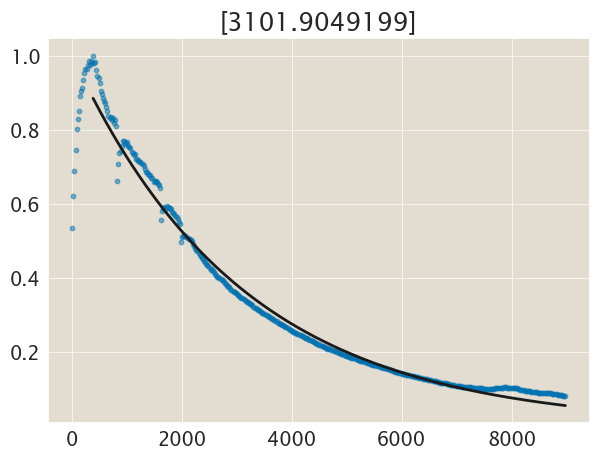

In [118]:
plt.scatter(time, norm_conc, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)
plt.title(str(params));

In [103]:
ATPsat = np.max(ratio_concavg1) #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.2895227236278488


In [112]:
norm_conc = (ratio_concavg1 - np.min(ratio_concavg1))/(np.max(ratio_concavg1)- np.min(ratio_concavg1))
params, curve = expfit(time[19:], norm_conc[19:], [2000])

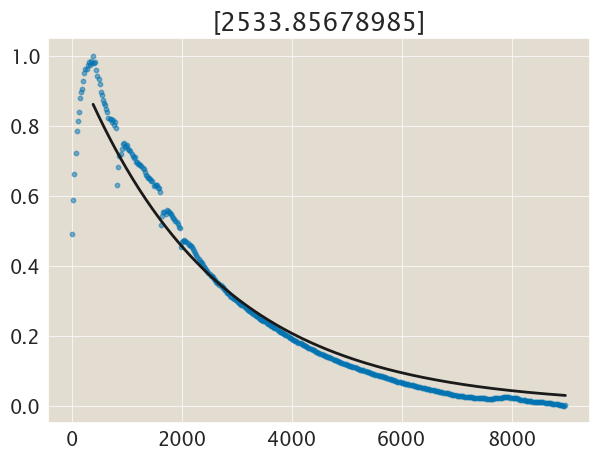

In [115]:
plt.scatter(time, norm_conc, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)
plt.title(str(params));

In [116]:
ATPsat = np.max(ratio_concavg1) #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.3544288550335928
